In [34]:
import keras
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [84]:
#check version of tensorflow
import random as rn

import numpy as np
import pandas as pd
import os
import glob
import datetime

In [85]:
df = pd.read_excel('Golbal_combined3.xlsx')

In [86]:
df.head()

,Date,Confirmed_cumulative,Confirmed,Confirmed_cumulative.1,Deaths,Recovered
0,43913,382799,38000,382799,16886,98355
1,43914,424883,42084,424883,19201,107974
2,43915,475998,51115,475998,22022,113753
3,43916,537412,61414,537412,25058,122125
4,43917,601349,63937,601349,28538,130910


In [87]:
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.x13
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots

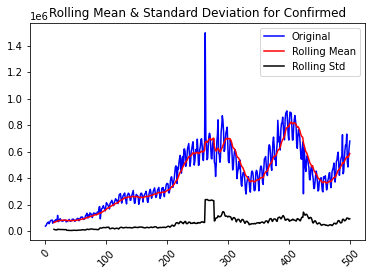

Results of Dickey-Fuller Test:
Test Statistic                  -1.947927
p-value                          0.309861
# Lags Used                     15.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64


In [88]:
def test_stationarity(df, ts):

    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 15, center = False).mean()
    rolstd = df[ts].rolling(window = 15, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts], color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()

    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = statsmodels.tsa.stattools.adfuller(df[ts], autolag='AIC') #add kpss
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value', '# Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#Applying the function to our Y variable: National Stock Exchange: Index: Nifty 500
test_stationarity(df, 'Confirmed')

In [89]:
#Defining a function to calculate percentage change
def percentChange(x,numLags):
    '''
    INPUTS:
    x: Column for which we want to calculate percent change
    numLags: The number of days from when the change needs to be calculated. 
            Example : If using daily data - numLags = 1 for daily change
                                            numLags = 30 for monthly change
                                            numLags = 365 for yearly change       
    OUTPUT:
    percentage change in variable
    '''
    y = (x - x.shift(numLags))/x.shift(numLags)
    return y

dataForMl = pd.DataFrame()
dataForMl['Date'] = df['Date']

#here, I only have level variables so I do not need separate my variables into level vs non-level variables
levelVars = df.columns[:-1]
for levelVar in levelVars:
    dataForMl[f'{levelVar}Ret'] = percentChange(df[levelVar],1)
    
dataForMl = dataForMl[1:] #ignoring the first row as it contains null values

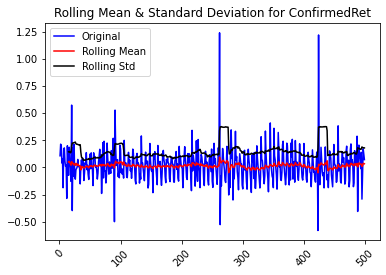

Results of Dickey-Fuller Test:
Test Statistic                  -5.491913
p-value                          0.000002
# Lags Used                     14.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64


In [92]:
test_stationarity(dataForMl, 'ConfirmedRet')

In [93]:
# We can make the acf and pacf plots using the statsmodels library in Python
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf

c:\users\sachin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


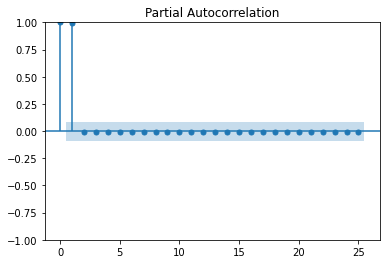

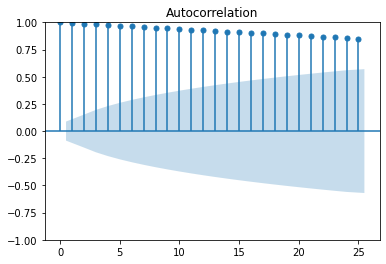

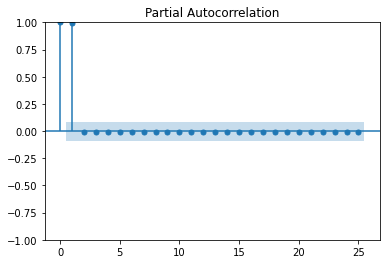

In [94]:
tsaplots.plot_acf(dataForMl['Date'].astype(float),lags =25)
tsaplots.plot_pacf(dataForMl['Date'].astype(float),lags =25)

In [95]:
# Since we're going to forecast the one day ahead Nifty stock returns, the minimum lag considered by me is 1
minLagNum = 1

#lagging the vars :here i'm iginoring the ACF and PACF lag structure and deciding the maximum number of lags heuristically
maxLagNum = 10 #here I have chosen the maxLagNum arbitrarily. A better strategy is to look at the acf plot
dataForMl = dataForMl.sort_values(['Date'])
for column in dataForMl.columns:
    for lag in range(minLagNum,maxLagNum+1):
        dataForMl[f'{column}Lag_{lag}'] = dataForMl[f'{column}'].shift(lag)
        

dataForMl.head(5)

,Date,DateRet,Confirmed_cumulativeRet,ConfirmedRet,Confirmed_cumulative.1Ret,DeathsRet,DateLag_1,DateLag_2,DateLag_3,DateLag_4,...,DeathsRetLag_1,DeathsRetLag_2,DeathsRetLag_3,DeathsRetLag_4,DeathsRetLag_5,DeathsRetLag_6,DeathsRetLag_7,DeathsRetLag_8,DeathsRetLag_9,DeathsRetLag_10
1,43914,0.000023,0.109938,0.107474,0.109938,0.137096,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43915,0.000023,0.120304,0.214595,0.120304,0.146919,43914.0,NaN,NaN,NaN,...,0.137096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43916,0.000023,0.129022,0.201487,0.129022,0.137862,43915.0,43914.0,NaN,NaN,...,0.146919,0.137096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43917,0.000023,0.118972,0.041082,0.118972,0.138878,43916.0,43915.0,43914.0,NaN,...,0.137862,0.146919,0.137096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,43918,0.000023,0.114985,0.081471,0.114985,0.134417,43917.0,43916.0,43915.0,43914.0,...,0.138878,0.137862,0.146919,0.137096,NaN,NaN,NaN,NaN,NaN,NaN


# Training, Validation and Testing

In [493]:
#breaking the data into train and test along time dim
df = pd.read_excel('Golbal_combined1.xlsx')
test_percent = 0.1
no_test_obs =  int(np.round(test_percent*len(df)))
training = df[:-no_test_obs]
testing = df[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.7
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]


# Rescaling Normalized Data

In [495]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
trainMinmax = min_max_scaler.fit_transform(training.values) #fit and transform training data
valMinmax = min_max_scaler.transform(validation.values)
outSampleMinmax = min_max_scaler.transform(outOfSample.values)

In [518]:
#breaking the data into independent variables (x) and dependent variables (y)

#training independent, dependent
trainMinmax_x,trainMinmax_y = trainMinmax[:,:-1],trainMinmax[:,-1] 

#validation independent, dependent
valMinmax_x,valMinmax_y = valMinmax[:,:-1],valMinmax[:,-1]

#out of sample testing independent, dependent
outSampleMinmax_x,outSampleMinmax_y = outSampleMinmax[:,:-1],outSampleMinmax[:,-1]

In [524]:
act_y = pd.DataFrame(outOfSample)
actual_y = act_y['Confirmed']

In [526]:
pred_y = outSampleMinmax_y
pred_y.dtype

dtype('float64')

# Checking for accuracy

In [521]:
from sklearn.metrics import mean_squared_error

In [522]:
outSampleMinmax_y

array([-0.44555893, -0.5385592 , -0.60211137, -0.53563893, -0.43429602,
       -0.41456158, -0.39149695, -0.34757227, -0.47343584, -0.54405698,
       -0.45951589, -0.33098569, -0.3145609 , -0.26174654, -0.23496644,
       -0.37955127, -0.47448878, -0.38542197, -0.3219123 , -0.29014992,
       -0.27696484, -0.05372883, -0.45828335, -0.44027091, -0.31429629,
       -0.22037333, -0.16088623, -0.17046005, -0.04769772, -0.34057322,
       -0.38824763, -0.27422966, -0.18214386, -0.1193101 ,         nan])

In [523]:
mean_squared_error(actual_y,outSampleMinmax_y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# SARIMA

In [429]:
#DEFINING SARIMA MODEL
import statsmodels.tsa.stattools
import statsmodels.api as sm
#(p,d,q) are determined using  Autocorrelation Function (ACF) , Partial Autocorrelation Functions (PACF) and tests for stationary.  
#How do we interpret ACF and PACF plots?

#p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
#q – Lag value where the ACF chart crosses the upper confidence interval for the first time.
p= 1 #the trend autoregressive order.
d= 0 #the trend difference order.
q= 1 #the trend moving average order

P= 1 #the number of seasonal autoregressive terms.
D= 0 #the number of seasonal difference terms
Q= 1 #the number of seasonal moving average terms
M=2 #the number of time steps for a seasonal period 
myorder = (p,d,q)
myseasonalorder = (P,D,Q,M)

In [430]:
model = sm.tsa.statespace.SARIMAX(trainMinmax_y,
                                  order=myorder, 
                                  seasonal_order=myseasonalorder,
                                  trend='c')#,exog=trainMinmax_x 


In [431]:
#Training the model
model_fit = model.fit() 

# In case you want to add exgogenous variables
#exogNormal = normalizer.transform(testing.values)
#exogMinmax = min_max_scaler.transform(exogNormal)
#exogMinmax_x,exogMinmax_y = exogMinmax[:,:-1],exogMinmax[:,-1]

#Predicting
totat_preds = len(testing)#len(exogMinmax_y)
sarimaPred = model_fit.predict(start=1, end=totat_preds)#exog=exogMinmax_x

c:\users\sachin\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [432]:
def plot_results(actual_y,predicted_y,method,date):
    mse = mean_squared_error(actual_y,predicted_y)
    
    plt.figure(figsize=(16,4))
    plt.plot(date,actual_y)
    plt.plot(date,predicted_y)
    plt.legend(['Actual','Predicted'])
    plt.title(f'{method} (MSE: {mse})')        
    plt.show()

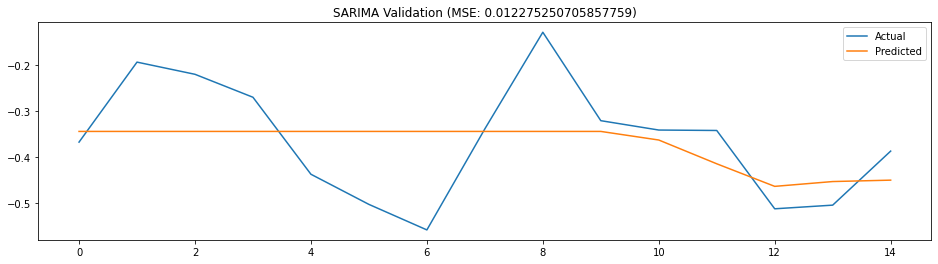

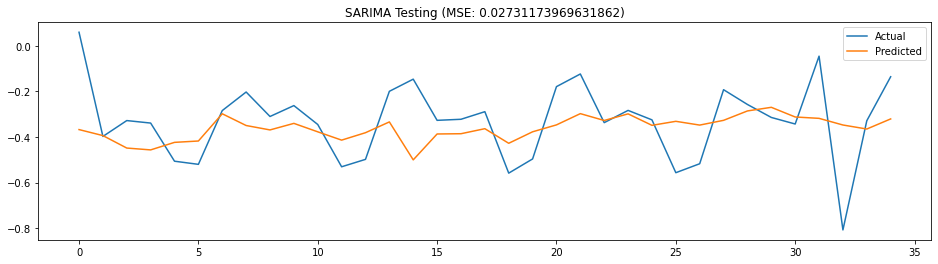

In [433]:
plot_results(valMinmax_y,sarimaPred[:len(valMinmax_y)],'SARIMA Validation',range(len(valMinmax_y)))
plot_results(outSampleMinmax_y,sarimaPred[len(valMinmax_y):],'SARIMA Testing',range(len(outSampleMinmax_y)))

# preserve the temporal structure of the data

In [434]:
from numpy import array

#split a multivariate sequence into samples that preserve the temporal structure of the data
#SOURCE:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [435]:
n_steps_in =30 #number of observations from the past that we assume to be relevant across time for forecasting
n_steps_out = 15 #number of units ahead that we want to forecast into the future

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

In [447]:
trainMinmax.shape #Output: (rows,columns)

(450, 66)

In [448]:
validationSeq_x

array([], dtype=float64)

In [437]:
trainSeq_x.shape #Output: (number of samples,size of 'window' /timesteps,number of independent variables)

(407, 30, 65)

# Convolutional Neural Network

In [438]:
# Implementing a neural network in Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling1D,MaxPooling1D
from keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l1,l2,l1_l2

In [439]:
############################# For Replicability : Always run this as one cell ##########################################
#SOURCE :
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)
# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

#tf.random.set_random_seed(1234)
tf.random.set_seed(1234)

In [440]:
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################

#While training the neural network, it is important that we use the MSE error of the validation set to decide when to 
#stop training our network. If we use the MSE of the training set, we will not get good predictions in the test set due 
#to over fitting. However, unlike the error in the training set, the error in the validation set does not reduce with 
#every passing epoch. Sometimes, it increases for a while before it starts declining. The patience argument in Earlystop allows us 
#to decide how many times we want the validation error to keep increasing before we stop training the neural network.

#EarlyStop = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

epochs = 100 #number of times the feed forward mechanism and back propagation are repeated 

bs = 100 #batch size for SGD :show what happens when batch size very small
lr =0 #learning rate: the degree to which the weights are updated by each batch of SGD

sgd = SGD(lr=lr) #type of optimizer - Alternative: ADAM, NADAM

X, y = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X.shape[2]

np.random.seed(0)

model = Sequential() #initializing keras Sequential model

#convolutional layer starts
model.add(Conv1D(filters=5,#number of filters
                 kernel_size=2,#size of the filte racross time
                 strides=2, #number of rows that the filter moves ahead by
                 activation='linear',#transformation
                 input_shape=(n_steps_in, n_features))) #shape of 1 sample : preserves temporal structure
                #kernel_regularizer=l2(0.009),, bias_regularizer=l2(0.01)
#convolutional layer ends

model.add(MaxPooling1D(pool_size=1)) #sub-sampling layer - Alternative: AveragePooling1D

#model.add(BatchNormalization())
model.add(Dropout(0.1)) #reduces overfitting by dropping some weights randomly

#regression layer begins
model.add(Flatten())
model.add(Dense(1,#number of outputs
                activation='tanh',#transformation:other options include - ReLU,Linear,Sigmoid
                kernel_regularizer=l2(0.01))) 

#model.compile(loss='mean_squared_error', optimizer='sgd') #specifies which optimizer and loss funtion to useto use 
model.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'],run_eagerly=True)
#training the model
model.fit(trainSeq_x, trainSeq_y,
          batch_size=bs,
          epochs=epochs, 
          callbacks= [EarlyStop],
          verbose=2, 
          shuffle=False,#always set to false for time series data
          validation_data =(validationSeq_x, validationSeq_y))

                         
    
    
model.summary()



Epoch 1/100


c:\users\sachin\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
c:\users\sachin\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 222ms/epoch - 44ms/step
Epoch 2/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 164ms/epoch - 33ms/step
Epoch 3/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 165ms/epoch - 33ms/step
Epoch 4/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 166ms/epoch - 33ms/step
Epoch 5/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 165ms/epoch - 33ms/step
Epoch 6/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 167ms/epoch - 33ms/step
Epoch 7/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 168ms/epoch - 34ms/step
Epoch 8/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 165ms/epoch - 33ms/step
Epoch 9/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 163ms/epoch - 33ms/step
Epoch 10/100
5/5 - 0s - loss: nan - accuracy: 0.0000e+00 - 163ms/epoch - 33ms/step
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 

In [441]:
# validation metrics 
#cnnValPred = model.predict(validationSeq_x)

#testing prediction
#cnnOutSamplePred = model.predict(outSampleSeq_x)
    
#plot_results(validationSeq_y ,cnnValPred  ,'CNN Validation',range(len(validationSeq_y)))
#plot_results(outSampleSeq_y ,cnnOutSamplePred  ,'CNN Testing',range(len(outSampleSeq_y)))